<a href="https://colab.research.google.com/github/eli-vigneron/Deep-Learning-Pytorch/blob/main/pre_image_logits_VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Goal**

The goal of this is to find pre-images of logits in the VGG19 model.

*Requires including a GPU!*


In [ ]:
import cv2
import torch
import torchvision
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

In [ ]:
lr = 0.1
weight_decay = 1e-6
interpolation_steps = 20
optimization_steps = 12

device = 'cuda'

In [ ]:
model = torchvision.models.vgg19(pretrained=True).eval().to(device)

def hook(module, input, output):
    module.output = output

# TASK 1: MODIFY CODE HERE
layer = model.classifier
layer.register_forward_hook(hook)

mean = torch.FloatTensor([0.485, 0.456, 0.406]).view(1,3,1,1).to(device)
std = torch.FloatTensor([0.229, 0.224, 0.225]).view(1,3,1,1).to(device)
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


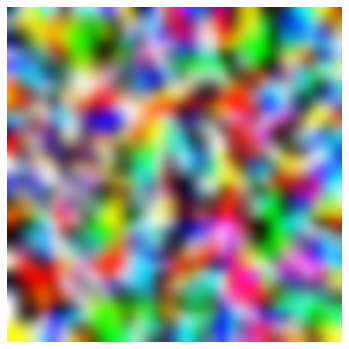

In [ ]:
filter_index = 31 

size = 32

image = torch.rand((1, 3, size, size), device=device)

from torch.autograd import Variable
image = Variable(image, requires_grad=True)

optimizer = torch.optim.Adam([image], lr=0.7, weight_decay=weight_decay)

for interpolation_step in range(1, interpolation_steps+1):

    for _ in range(optimization_steps):
        model(image)
        feature = layer.output
        optimizer.zero_grad()
        loss = -feature[0, filter_index].mean()
        loss.backward()
        optimizer.step()
        
    tmp = torch.clamp(image*std + mean, min=0, max=1)
    np_image = tmp.squeeze(0).permute(1,2,0).detach().cpu().numpy()

    # TASK 2: ADD CODE HERE
    np_image = cv2.resize(np_image, None, fx = 1.2, fy = 1.2)
    np_image = cv2.GaussianBlur(np_image, (1,1), 0)

    plt.figure(figsize=(12,6))
    plt.matshow(np_image, fignum=1)
    plt.axis('off')
    plt.show()
    clear_output(wait=True)

    image_tensor = torch.from_numpy(np_image).permute(2,1,0).unsqueeze(0).to(device)
    image = (image_tensor - mean) / std